In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import scipy.integrate as integrate 
from scipy.stats import lognorm 
from scipy.special import gamma

In [16]:
#include "usincmoms.txt"

data = pd.read_csv("usincmoms.txt", sep = "\t", header=None)
midpoints = np.array(data[1])
percentages = np.array(data[0])
midpoints = midpoints / 1000
print(midpoints[:-2])
print(midpoints[:])

bins = np.arange(0, 200001, 5000)
bins = np.append(bins, [250000, 350000])
bins = bins / 1000



[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5
 122.5 127.5 132.5 137.5 142.5 147.5 152.5 157.5 162.5 167.5 172.5 177.5
 182.5 187.5 192.5 197.5]
[  2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5  57.5
  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5
 122.5 127.5 132.5 137.5 142.5 147.5 152.5 157.5 162.5 167.5 172.5 177.5
 182.5 187.5 192.5 197.5 225.  300. ]


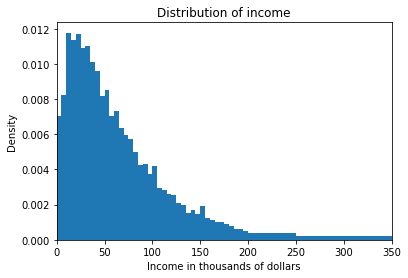

In [17]:
plt.bar(midpoints[:-2], percentages[:-2]/5, width = 5, color = "#1f77b4")
plt.bar(midpoints[-1], percentages[-1]/100, width = 100, color = "#1f77b4")
plt.bar(midpoints[-2], percentages[-2]/50, width = 50, color = "#1f77b4")
plt.xlim(0,350)
plt.xlabel("Income in thousands of dollars")
plt.ylabel("Density")
plt.title("Distribution of income")
plt.show()

In [18]:
# the lognormal pdf is given by lognorm.pdf(x, s = sigma, scale = np.exp(mu))
# the lognormal cdf is given by lognorm.cdf(x, s = sigma, scale = np.exp(mu))


In [19]:
# we already have data moments, now we need model moments 
print(bins)

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 250.
 350.]


In [35]:
data_moments = np.array(data[0])
def get_model_moments(param_vec):
    mu, sigma = param_vec
    model_moments = []
    for i in range(1, len(bins)):
        model_moments.append(lognorm.cdf(bins[i]*1000, s = sigma, scale = np.exp(mu)) - 
                             lognorm.cdf(bins[i-1]*1000, s = sigma, scale = np.exp(mu)))
    return np.array(model_moments)

def crit1(param_vec, args):
    model_m = get_model_moments(param_vec)
    data_m = np.array(data[0])
    error_vec = (model_m - data_m) / data_m
    #print(error_vec)
    W = args
    return error_vec.T @ W @ error_vec

In [41]:
# Use GMM to estimate parameters
W = np.diag(data_moments)
#print(W)


soln1 = opt.minimize(crit1, [10, 1], args = W, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
soln1

      fun: 0.03551648133834282
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.18852714e-06, 4.22231694e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 6
   status: 0
  success: True
        x: array([10.80120182,  0.97573873])

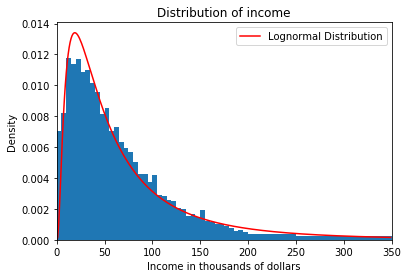

In [44]:
xxxx= np.arange(1, 350000,1000)
yyyy = lognorm.pdf(xxxx, s = soln1.x[1], scale = np.exp(soln1.x[0]))
plt.plot(yyyy * 1000, "r", label = "Lognormal Distribution")
plt.bar(midpoints[:-2], percentages[:-2]/5, width = 5, color = "#1f77b4")
plt.bar(midpoints[-1], percentages[-1]/100, width = 100, color = "#1f77b4")
plt.bar(midpoints[-2], percentages[-2]/50, width = 50, color = "#1f77b4")
plt.xlim(0,350)
plt.xlabel("Income in thousands of dollars")
plt.ylabel("Density")
plt.title("Distribution of income")
plt.legend()
plt.show()

In [63]:
# fit a gamma distribution
# data moments are still the percentiles
# model moments need to be calculated from given parameters

#get initial guess 

xpdf = lambda x : x*lognorm.pdf(x, s = soln1.x[1], scale = np.exp(soln1.x[0]))
estimated_mean = integrate.quad(xpdf, 0, 400000)[0]
varpdf = lambda x: (x-estimated_mean)**2 * lognorm.pdf(x, s = soln1.x[1], scale = np.exp(soln1.x[0]))
estimated_var = integrate.quad(varpdf, 0, 400000)[0]
#print(estimated_mean)
#print(estimated_var)
#print(estimated_var ** 2 *2)
def gamma_density(x, args):
    alpha, beta = args
    return 1.0 / ((beta ** alpha) * gamma(alpha)) * x **(alpha-1) * np.exp(-x/beta)

def get_gamma_moments(param_vec):
    model_moments =[]
    for i in range(1, len(bins)):
        model_moments.append(integrate.quad(gamma_density, bins[i-1]*1000, bins[i]*1000, args = param_vec)[0])
    return np.array(model_moments)
    
def crit_gamma(param_vec, args):
    W = args
    gamma_moments = get_gamma_moments(param_vec)
    data_moments = np.array(data[0])
    err_vec = (gamma_moments - data_moments) / data_moments
    return err_vec.T @ W @ err_vec
    
init_guess = np.array([3, 20000])

soln2 = opt.minimize(crit_gamma, init_guess, args = W, bounds = ((1e-5, None), (1e-5, None)))
soln2
#print(get_gamma_moments(np.array([3, 20000])))
        
        
    

      fun: 0.014084919603247072
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.44516082e-07, 6.93889390e-10])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 108
      nit: 29
   status: 0
  success: True
        x: array([1.36705468e+00, 4.80629943e+04])

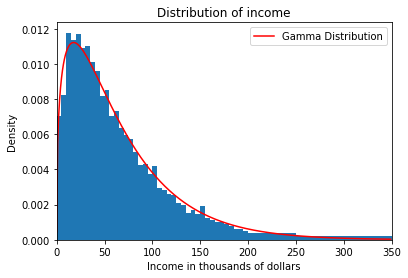

In [65]:
model_alpha, model_beta = soln2.x
xxx= np.arange(1, 350000,1000)
yyy = gamma_density(xxx, np.array([model_alpha, model_beta]))
plt.plot(yyy * 1000, "r", label = "Gamma Distribution")
plt.bar(midpoints[:-2], percentages[:-2]/5, width = 5, color = "#1f77b4")
plt.bar(midpoints[-1], percentages[-1]/100, width = 100, color = "#1f77b4")
plt.bar(midpoints[-2], percentages[-2]/50, width = 50, color = "#1f77b4")
plt.xlim(0,350)
plt.xlabel("Income in thousands of dollars")
plt.ylabel("Density")
plt.title("Distribution of income")
plt.legend()
plt.show()

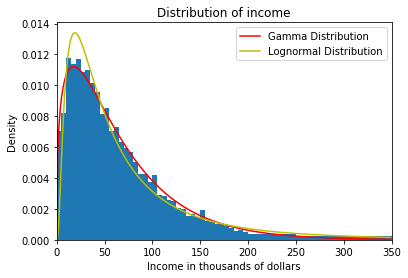

Let us see the error term
Lognormal distribution:  0.03551648133834282
Gamma distribution:      0.014084919603247072


In [68]:
#Compare two estimates
plt.plot(yyy * 1000, "r", label = "Gamma Distribution")
plt.plot(yyyy* 1000, "y", label = "Lognormal Distribution")
plt.bar(midpoints[:-2], percentages[:-2]/5, width = 5, color = "#1f77b4")
plt.bar(midpoints[-1], percentages[-1]/100, width = 100, color = "#1f77b4")
plt.bar(midpoints[-2], percentages[-2]/50, width = 50, color = "#1f77b4")
plt.xlim(0,350)
plt.xlabel("Income in thousands of dollars")
plt.ylabel("Density")
plt.title("Distribution of income")
plt.legend()
plt.show()

print("Let us see the error term")
print("Lognormal distribution: ", soln1.fun)
print("Gamma distribution:     ", soln2.fun)

In [69]:
print("From both the graph and the error magnitude we can confirm that the gamma distribution better fits the data.")

From both the graph and the error magnitude we can confirm that the gamma distribution better fits the data.


In [78]:
#estimate gamma distri using two-step W
#first use the identity matrix to estimate and get error vector
W = np.eye(len(data_moments))
soln_for_w_est = opt.minimize(crit_gamma, [3, 20000], args = W, bounds = ((1e-5, None), (1e-5, None)))
soln_for_w_est

/Users/Zeshun/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


      fun: 0.7388929283856575
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.66133815e-08, -1.11022302e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 168
      nit: 30
   status: 0
  success: True
        x: array([1.37437565e+00, 4.62109297e+04])

In [82]:
# Use the estimated parameters to get the error vector
alpha_hat1, beta_hat1 = soln_for_w_est.x
gamma_moments_hat1 = get_gamma_moments([alpha_hat1, beta_hat1])
err_vec_hat1 = (gamma_moments_hat1 - data_moments) / data_moments
#print(err_vec_hat1)
W_hat = np.outer(err_vec_hat1, err_vec_hat1) / 42
W_hat

[ 0.0285778   0.26782524 -0.03527632  0.01816519 -0.02572247  0.01496084
 -0.04121335 -0.01349685 -0.01750604  0.07730973 -0.0398886   0.08453205
 -0.03702902  0.02770746  0.00776898 -0.0313256   0.01188076  0.09839273
 -0.00437696  0.05017955 -0.14458028  0.11512499  0.0463137   0.04811142
 -0.0265852   0.08556263  0.02673363  0.23251941 -0.00184738  0.04766604
 -0.27086585  0.04359244  0.00605658  0.04343126 -0.06394385 -0.01151995
  0.03279337  0.18650615  0.02726546  0.13368277 -0.07186417 -0.6218467 ]


array([[ 1.94450167e-05,  1.82234674e-04, -2.40028496e-05, ...,
         9.09609398e-05, -4.88980918e-05, -4.23119316e-04],
       [ 1.82234674e-04,  1.70786566e-03, -2.24949741e-04, ...,
         8.52467110e-04, -4.58262801e-04, -3.96538670e-03],
       [-2.40028496e-05, -2.24949741e-04,  2.96290201e-05, ...,
        -1.12281815e-04,  6.03596059e-05,  5.22296765e-04],
       ...,
       [ 9.09609398e-05,  8.52467110e-04, -1.12281815e-04, ...,
         4.25501952e-04, -2.28738111e-04, -1.97929018e-03],
       [-4.88980918e-05, -4.58262801e-04,  6.03596059e-05, ...,
        -2.28738111e-04,  1.22963298e-04,  1.06401180e-03],
       [-4.23119316e-04, -3.96538670e-03,  5.22296765e-04, ...,
        -1.97929018e-03,  1.06401180e-03,  9.20698390e-03]])

In [84]:
soln3 = opt.minimize(crit_gamma, [3, 20000], args = W_hat, bounds = ((1e-5, None), (1e-5, None)))
soln3

      fun: 0.0019354323447605807
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.8660108e-06,  4.6924270e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 4
   status: 0
  success: True
        x: array([2.33235478e+00, 1.99999998e+04])

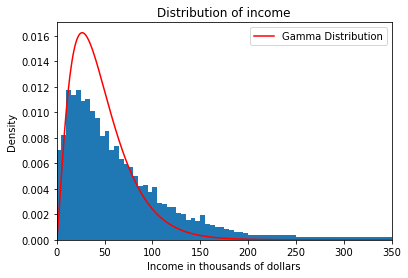

In [85]:
alpha_2stepW, beta_2stepW = soln3.x
xx= np.arange(1, 350000,1000)
yy = gamma_density(xx, np.array([alpha_2stepW, beta_2stepW]))
plt.plot(yy * 1000, "r", label = "Gamma Distribution")
plt.bar(midpoints[:-2], percentages[:-2]/5, width = 5, color = "#1f77b4")
plt.bar(midpoints[-1], percentages[-1]/100, width = 100, color = "#1f77b4")
plt.bar(midpoints[-2], percentages[-2]/50, width = 50, color = "#1f77b4")
plt.xlim(0,350)
plt.xlabel("Income in thousands of dollars")
plt.ylabel("Density")
plt.title("Distribution of income")
plt.legend()
plt.show()

In [86]:
print("Although the error term is smaller, from the eyeball test it seems to be worse.")

Although the error term is smaller, from the eyeball test it seems to be worse.
